In [2]:
# Read Data, PCA and Pickle to ave time when re-learning
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
import matplotlib.pyplot as plt
import pandas as pd



def read_data(data_path):
    return anndata.read_csv(data_path)

def preprocess_data(adata: anndata.AnnData, scale :bool=True):
    """Preprocessing dataset: filtering genes/cells, normalization and scaling."""
    sc.pp.filter_cells(adata, min_counts=5000)
    sc.pp.filter_cells(adata, min_genes=500)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.raw = adata

    sc.pp.log1p(adata)
    if scale:
        sc.pp.scale(adata, max_value=10, zero_center=True)
        adata.X[np.isnan(adata.X)] = 0

    return adata


def PCA(X, num_components: int):
    return pca(num_components).fit_transform(X)

# def main():
data_path = 'data/scRNAseq_human_pancreas.csv'
heart = read_data(data_path)
heart = preprocess_data(heart)
X = PCA(heart.X, 100)
df = pd.DataFrame(X)
df.to_pickle('processed_data.pkl')

In [ ]:
# Learn

import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
import matplotlib.pyplot as plt
from kmeans import KMeans
# Loading processed data
loaded_data = pd.read_pickle('processed_data.pkl').to_numpy()

knn = KMeans(3)
learnt_clustering, learnt_centroids = knn.fit(loaded_data)

In [ ]:
# Print number of points per cluster
print(f'clustering 1: {learnt_clustering[0].shape}')
print(f'clustering 2: {learnt_clustering[1].shape}')
print(f'clustering 3: {learnt_clustering[2].shape}')

print(f'total points: {learnt_clustering[2].shape[0]+learnt_clustering[1].shape[0]+learnt_clustering[0].shape[0]}')

clustering 1: (2721, 100)
clustering 2: (38, 100)
clustering 3: (1600, 100)
total points: 4359


done fitting


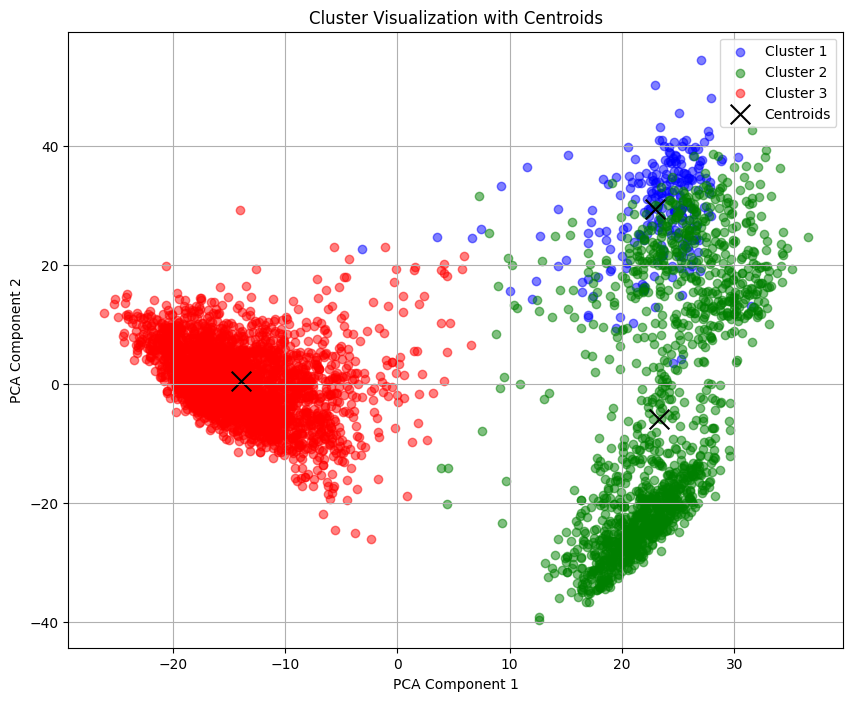

silhouette score: 0.3510348017915404


In [6]:
# Learn and Plot

import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
import matplotlib.pyplot as plt
from kmeans import KMeans
# Loading processed data
loaded_data = pd.read_pickle('processed_data.pkl').to_numpy()

knn = KMeans(3, 'kmeans++', 300)
learnt_clustering, learnt_centroids, _ = knn.fit(loaded_data)

print('done fitting')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data
clstrs = learnt_clustering  # Replace with your data
cntrds = learnt_centroids  # Replace with your centroids

# Combine clusters into a single array for PCA
all_points = np.vstack(clstrs)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_points = pca.fit_transform(all_points)

# Plotting
plt.figure(figsize=(10, 8))

colors = ['b','g','r','c','m','y','k']
for i, cluster in enumerate(clstrs):
    cluster_reduced = pca.transform(cluster)  # Transform the cluster to 2D
    plt.scatter(cluster_reduced[:, 0], cluster_reduced[:, 1], color=colors[i], label=f'Cluster {i + 1}', alpha=0.5)

# Plot centroids
centroid_reduced = pca.transform(np.vstack(cntrds))
plt.scatter(centroid_reduced[:, 0], centroid_reduced[:, 1], color='k', marker='x', s=200, label='Centroids')

plt.title('Cluster Visualization with Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

print(f'silhouette score: {knn.silhouette(learnt_clustering, loaded_data)}')

In [ ]:
# Assignment Q2
import pandas as pd
import numpy as np
from kmeans import KMeans

X = pd.read_pickle('processed_data.pkl').to_numpy()

rand_silh_scores = np.zeros(9)
tot = 0

for i in range(2, 11):
    print(f'k = {i}')
    for j in range(0, 20):
        rand_kmeans = KMeans(i, 'random')
        rand_learnt_clustering, _, _ = rand_kmeans.fit(X)
        tot = tot + rand_kmeans.silhouette(rand_learnt_clustering, X)
    rand_silh_scores[i-2] = tot / 20
    tot=0

print(rand_silh_scores)

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
[0.56498322 0.24449726 0.21702003 0.40991679 0.27420563 0.27131442
 0.26083658 0.25646352 0.        ]


In [ ]:
# Assignment Q3
import pandas as pd
import numpy as np
from kmeans import KMeans

X = pd.read_pickle('processed_data.pkl').to_numpy()

pp_silh_scores = np.zeros(9)
tot=0
for i in range(2, 11):
    print(f'k = {i}')
    for j in range(0, 20):
        pp_kmeans = KMeans(i, 'kmeans++')
        pp_learnt_clustering, _, _ = pp_kmeans.fit(X)
        tot = tot + pp_kmeans.silhouette(pp_learnt_clustering, X)
    pp_silh_scores[i-2] = tot / 20
    tot=0

print(pp_silh_scores)

k = 2


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


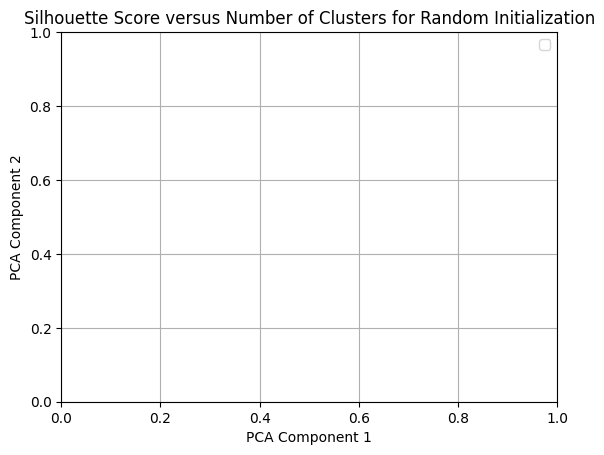

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

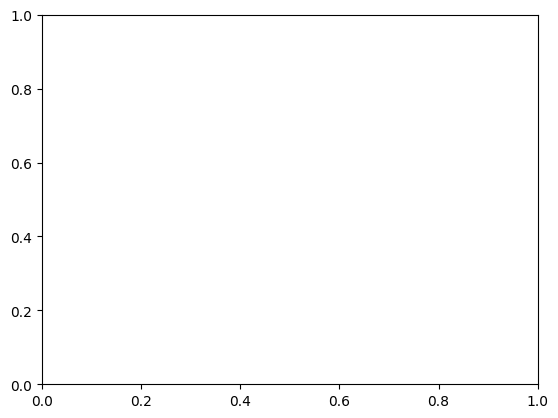

In [ ]:
# Plot for Q2,3 Silh vs k

import matplotlib.pyplot as plt

K = range(2,11)

plt.figure(figsize=(10, 8))
plt.title('Silhouette Score versus Number of Clusters for Random Initialization')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.plot(K, rand_silh_scores)
plt.show()

plt.figure(figsize=(10, 8))
plt.title('Silhouette Score versus Number of Clusters for KMeans++ Initialization')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.plot(K, pp_silh_scores)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kmeans import KMeans as myKM
import pandas as pd

def generate_plot(clstrs, cntrds, init, k):
    # Combine clusters into a single array for PCA
    all_points = np.vstack(clstrs)

    # Perform PCA to reduce to 2D
    pca = PCA(n_components=2)
    reduced_points = pca.fit_transform(all_points)

    # Plotting
    plt.figure(figsize=(10, 8))

    colors = ['b','g','r','c','m','y']
    for i, cluster in enumerate(clstrs):
        cluster_reduced = pca.transform(cluster)  # Transform the cluster to 2D
        plt.scatter(cluster_reduced[:, 0], cluster_reduced[:, 1], color=colors[i], label=f'Cluster {i + 1}', alpha=0.5)

    # Plot centroids
    centroid_reduced = pca.transform(np.vstack(cntrds))
    plt.scatter(centroid_reduced[:, 0], centroid_reduced[:, 1], color='k', marker='x', s=200, label='Centroids')

    plt.title(f'Cluster Visualization with Centroids for {init} Initialization and Best k = {k}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid()
    plt.show()

X = pd.read_pickle('processed_data.pkl').to_numpy()

best_rand_km = myKM(n, 'random')
best_pp_km = myKM(n, 'kmeans++')

rand_clstr, rand_cntrd, _ = best_rand_km.fit(X)
pp_clstr, pp_cntrd, _ = best_pp_km.fit(X)

generate_plot(rand_clstr, rand_cntrd, 'Random', n)
generate_plot(pp_clstr, pp_cntrd, 'KMeans++', n)

e:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


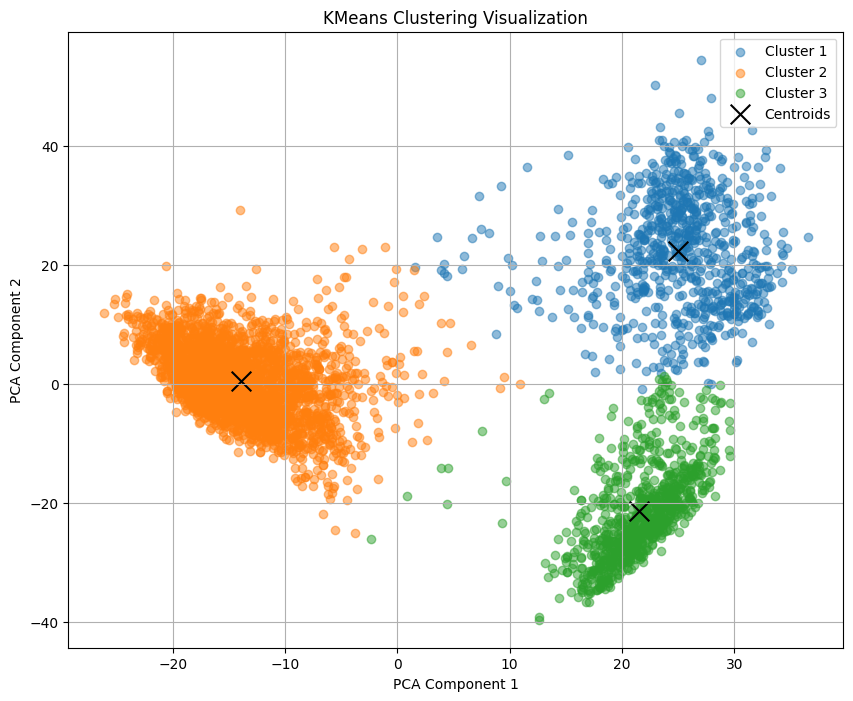

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming loaded_data is your data in the form of an ndarray
# Example data (replace this with your actual loaded data)
# loaded_data = np.random.rand(300, 100)  # Example with 300 points in 100D

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, init='random', max_iter=300)
kmeans.fit(loaded_data)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(loaded_data)
reduced_centroids = pca.transform(centroids)

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plot for each cluster
for i in range(3):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'Cluster {i + 1}', alpha=0.5)

# Plot centroids
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], color='k', marker='x', s=200, label='Centroids')

plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Calculate the distance matrix between the two sets of centroids
distance_matrix = cdist(learnt_centroids, centroids)
print(distance_matrix)
# Find the minimum distance from each original centroid to any KMeans centroid
min_distances = np.min(distance_matrix, axis=0)

# Calculate the average of those minimum distances
average_distance = np.mean(min_distances)

print(f'Average distance between closest pairs of centroids: {average_distance}')

[[46.32299883 42.29736371  7.74194389]
 [45.7197836  45.31396626 15.812467  ]
 [23.63701511 20.87428836 37.31473621]]
Average distance between closest pairs of centroids: 17.417749120160305
